In [1]:
# prepare the wine dataset
import pandas as pd
import numpy as np

# import the wine dataset
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)
df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 
                   'Ash', 'Alcalinity of ash', 'Magnesium', 
                   'Total phenols', 'Flavanoids', 'Nonflavanoid phenols', 
                   'Proanthocyanins', 'Color intensity', 'Hue', 
                   'OD280/OD315 of diluted wines', 'Proline'
                  ]

# randomly partition the wine dataset for test & training datasets
from sklearn.model_selection import train_test_split
X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# normilizing data via min-max scaling
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
X_train_norm = mms.fit_transform(X_train)
X_test_norn = mms.transform(X_test)

# data standardization
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

In [2]:
# implementing SBS algorithm
from sklearn.base import clone
from itertools import combinations
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
class SBS():
    def __init__(self, estimator, k_features, scoring=accuracy_score, test_size=0.25,  random_state=1):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state
        
    def fit(self, X, y):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=self.test_size, random_state=self.random_state)
        
        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train, X_test, y_test, self.indices_)
        self.scores_ = [score]
        
        while dim > self.k_features:
            scores = []
            subsets = []
            
            for p in combinations(self.indices_, r=dim-1):
                score = self._calc_score(X_train, y_train, X_test, y_test, p)
                scores.append(score)
                subsets.append(p)
                
            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1
            
            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]
        
        return self

    def transform(self, X):
        return X[:, self.indices_]
    
    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score

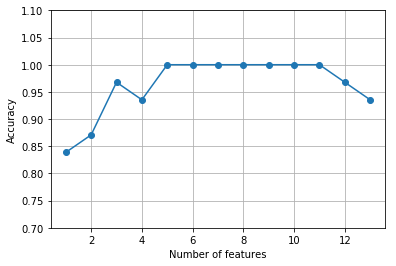

In [3]:
# use SBS with the KNN classifier
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
knn = KNeighborsClassifier(n_neighbors=2)
sbs = SBS(knn, k_features=1)
sbs.fit(X_train_std, y_train)

# plotting the classification accuracy of the KNN classifier
k_feat = [len(k) for k in sbs.subsets_]
plt.plot(k_feat, sbs.scores_, marker='o')
plt.ylim([0.7, 1.1])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()
plt.show()


In [4]:
# show 5 features that are yielded good performance on the validation dataset
k5 = list(sbs.subsets_[8])
print(df_wine.columns[1:][k5])

Index(['Alcohol', 'Malic acid', 'Alcalinity of ash', 'Hue', 'Proline'], dtype='object')


In [5]:
# evaluate the performance of the KNN classifier on the original test set
knn.fit(X_train_std, y_train)
print('Training accuracy: ', knn.score(X_train_std, y_train))

Training accuracy:  0.983870967742


In [6]:
print('Test accuracy: ', knn.score(X_test_std, y_test))

Test accuracy:  0.944444444444


In [7]:
# now check the KNN performance using only the k5-feature subset
knn.fit(X_train_std[:, k5], y_train)
print('Training accuracy: ', knn.score(X_train_std[:, k5], y_train))
print('Test accuracy: ', knn.score(X_test_std[:, k5], y_test))

Training accuracy:  0.959677419355
Test accuracy:  0.962962962963
